In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


# Introduction
In the financial industry, fraud detection is an important topic. However, because of privacy issues, raw public data is nowhere to be found. Some competitions and datasets available on kaggle are genuine data but were all PCA transformed.

This dataset that we will be working on is a synthetic dataset created based on real mobile transactions in an African country. 

# 1. Exploratory Data Analysis
## 1.1 Import Data
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns = {'oldbalanceOrg':'oldbalanceOrig'})
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.2 Looking Into Each Column

- Starting from left side of the table, the first idea to test is: Fradulent transactions are an extremely tiny portion of the entire dataset, while transactions like debit and cash-in should rarely be fraudulent.
 - Conclusion: A total of ~8000 fradulent transactions within 6 million rows. For type of transactions: only transfer and cash_out types have fradulent transactions, and they are balanced: each has ~4000 cases.

In [3]:
print('Fradulent transactions only happens in',df[df['isFraud'] == 1].type.drop_duplicates().values)
print('Balanced fradulent types:',' TRANSFER has',df[df['isFraud'] == 1].type.value_counts()[1],'cases.','CASH_OUT has',df[df['isFraud'] == 1].type.value_counts()[0],'cases.')

Fradulent transactions only happens in ['TRANSFER' 'CASH_OUT']
Balanced fradulent types:  TRANSFER has 4097 cases. CASH_OUT has 4116 cases.


- isFlaggedFraud as described, flags transactions more than 200,000 as fraud.

 - However, it is not entirely true: flagged transfers are all > 200,000, but ~80% of unflagged transfers are also > 200,000.
 - Because the definition is unclear, will drop before feeding to model

In [4]:
print('The maximum transfer amount for unflagged transaction is', df[(df['isFlaggedFraud'] == 0) & (df['type'] == 'TRANSFER')].amount.max())
print('The minimum transfer amount for flagged transaction is', df[(df['isFlaggedFraud'] == 1) & (df['type'] == 'TRANSFER')].amount.min())

The maximum transfer amount for unflagged transaction is 92445516.64
The minimum transfer amount for flagged transaction is 353874.22


Text(0.7, 0.7, '- Among millions of transactions, 15 were accurately flagged.')

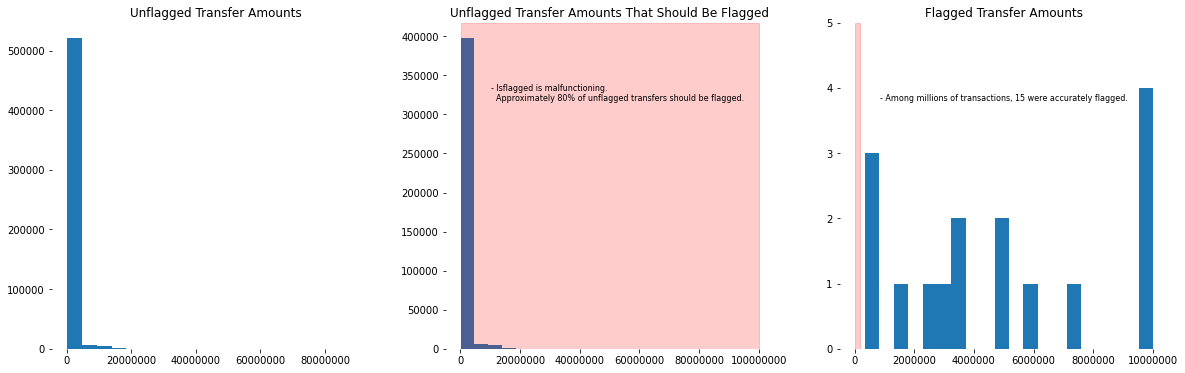

In [5]:
# visualization of flagged and unflagged transfer amounts.
import matplotlib.pyplot as plt
# extract data
unflagged_amount = df[(df['isFlaggedFraud'] == 0) & (df['type'] == 'TRANSFER')].amount
unflagged_amount_passthre = df[(df['isFlaggedFraud'] == 0) & (df['type'] == 'TRANSFER') & (df['amount'] >= 200000)].amount
flagged_amount = df[(df['isFlaggedFraud'] == 1) & (df['type'] == 'TRANSFER')].amount
# plot histograms
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.hist(unflagged_amount, bins = 20)
ax2.hist(unflagged_amount_passthre, bins = 20)
ax3.hist(flagged_amount, bins = 20)
# set ticks
ax3.set_yticks([0,1,2,3,4,5])
# remove scientific notations
ax1.xaxis.get_major_formatter().set_scientific(False)
ax2.xaxis.get_major_formatter().set_scientific(False)
ax3.xaxis.get_major_formatter().set_scientific(False)
# add titles
ax1.title.set_text('Unflagged Transfer Amounts')
ax2.title.set_text('Unflagged Transfer Amounts That Should Be Flagged')
ax3.title.set_text('Flagged Transfer Amounts')
# remove spines
ax1.spines[['bottom','left','top','right']].set_visible(False)
ax2.spines[['bottom','left','top','right']].set_visible(False)
ax3.spines[['bottom','left','top','right']].set_visible(False)
# add a note
ax3.axvspan(0,200000,color = 'red', alpha = 0.2)
ax2.axvspan(200000,100000000,color = 'red', alpha = 0.2)
fig.text(0.43,0.7,'''
- Isflagged is malfunctioning. 
  Approximately 80% of unflagged transfers should be flagged.''',fontsize = 8)
fig.text(0.7,0.7,'- Among millions of transactions, 15 were accurately flagged.',fontsize = 8)

# 2. Data Cleaning & Feature Engineering

## 2.1 Data Cleaning

From EDA we know that only transfer and cash_out transaction types can be fraudulent. Thus we only select transactions that correspond to these 2 types.

In [6]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y = X['isFraud']
# drop target value as well as irrelevant columns
X = X.drop(columns = {'isFraud','isFlaggedFraud','nameOrig','nameDest'}, axis = 1)

## 2.2 Feature Engineering

We want to convert type into 0s and 1s.

In [7]:
# We want to one-hot-encoding type column.
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT','type'] = 1
X.type = X.type.astype(int) # convert to integer
X.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


Since there is a huge difference between genuine transactions and fraudulent transactions here, we create 2 new features that record the 'errors'.

In [8]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [9]:
X['errorbalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrig
X['errorbalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

# 3. Visualization

The goal here is to find out the significances of some features.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

## 3.1 Dispersion over Time
It shows that there's no time pattern for fradulent transactions, while there is a clear time pattern for genuine transactions. A hypothesis is, during mid-night, genuine transactions happen much less frequently fradulent transactions.

In [11]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y,hue = hue, jitter = 0.4, marker = '.', size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 16);
    return ax

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


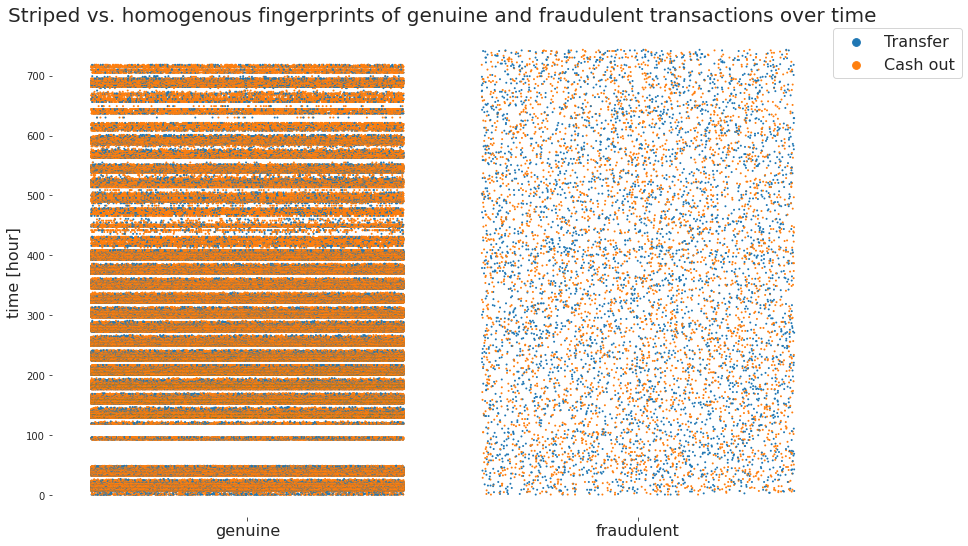

In [12]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20);
ax.spines[['bottom','left','top','right']].set_visible(False)

## 3.2 Dispersion over Amount
Fraudulent transactions have a clear "ceiling" while genuine transactions do not. Therefore amount can also be a significant feature here.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


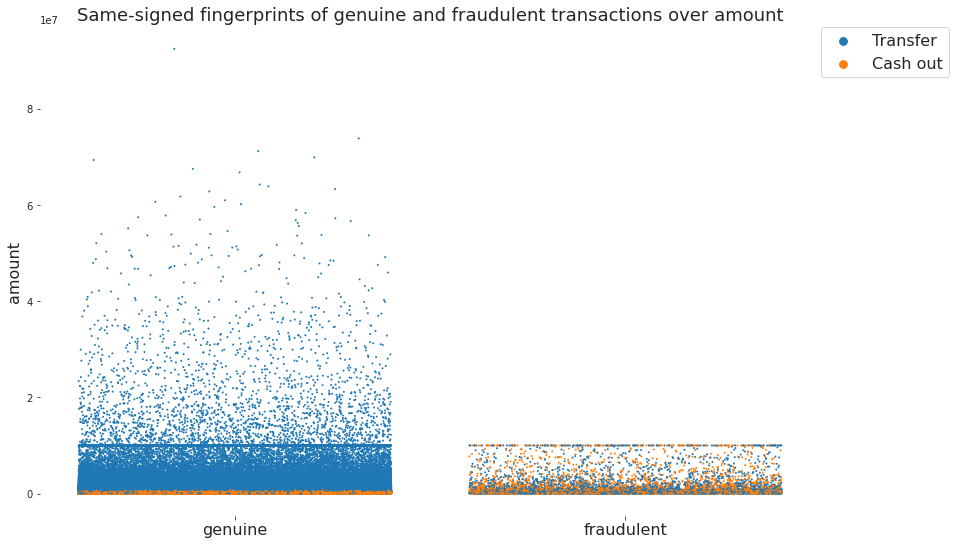

In [13]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);
ax.spines[['bottom','left','top','right']].set_visible(False)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


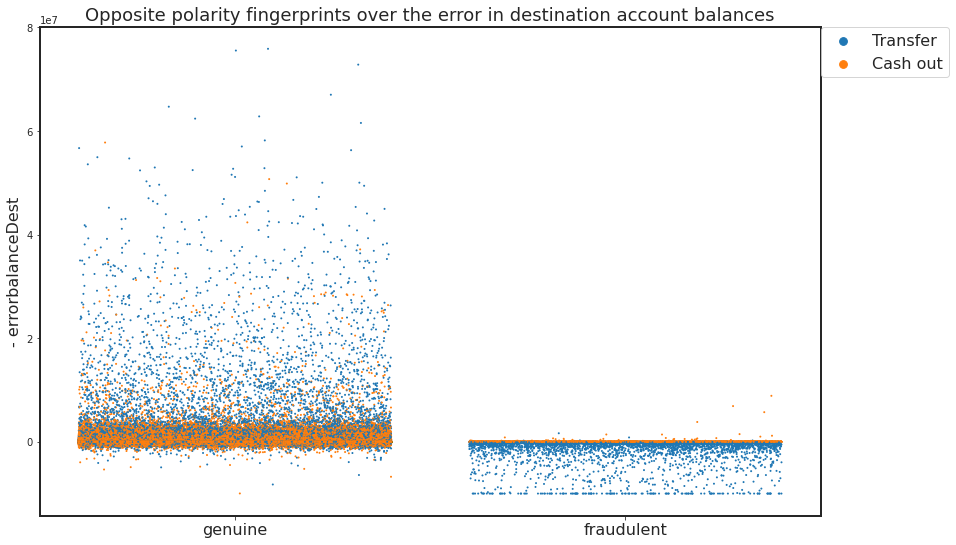

In [14]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorbalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorbalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

# 4. Machine Learning

For a classification task, we can select from a variety of ML algorithms: logistic regression, SVM, Anomaly Detection, random forest, XGBoost, etc.

Instead of going through all models and test, I think that given the imbalanced nature of the dataset, there is a much higher chance that a tree ensemble model performs better than the rest. Thus, we are going use XGBoost here, which is a highly popular model in kaggle community.


In [10]:
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [11]:
# train test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [13]:
# name weights for xgboost.
weights = (Y == 0).sum()/(Y == 1).sum()

In [20]:
# Hyperparameter tuning, here we use random search instead of grid search to save time (since it is a large dataset).
param_dist = {'learning_rate': np.linspace(0.01,0.4,10), 'n_estimators': range(100,1000,5), 'max_depth': range(2,10,2), 'min_child_weight': range(1,9,1),
                'colsample_bytree': np.linspace(0.5,0.98,10),'subsample': np.linspace(0.7,0.9,10)}
clf = XGBClassifier(scale_pos_weight = weights)
randsearch = RandomizedSearchCV(clf, param_dist, refit = True, verbose = 2, cv= 3, n_iter = 20, n_jobs = -1)
randsearch.fit(trainX,trainY)
print('best parameters are:', randsearch.best_params_)
print('best score is:',randsearch.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 178.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 286.7min finished
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:43:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameters are: {'subsample': 0.8555555555555556, 'n_estimators': 705, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.22666666666666668, 'colsample_bytree': 0.6066666666666667}
best score is: 0.999988720076868


In [14]:
# Therefore we have our best hyper-parameters tuned, run in test set.
tuned_params = {'learning_rate': 0.2267,'n_estimators': 705, 'subsample':0.8556,
              'min_child_weight': 6, 'max_depth': 6, 'colsample_bytree': 0.6067,'scale_pos_weight': weights, 'n_jobs': -1}
tuned_clf = XGBClassifier(**tuned_params)
probabilities = tuned_clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:42:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9964041436285649


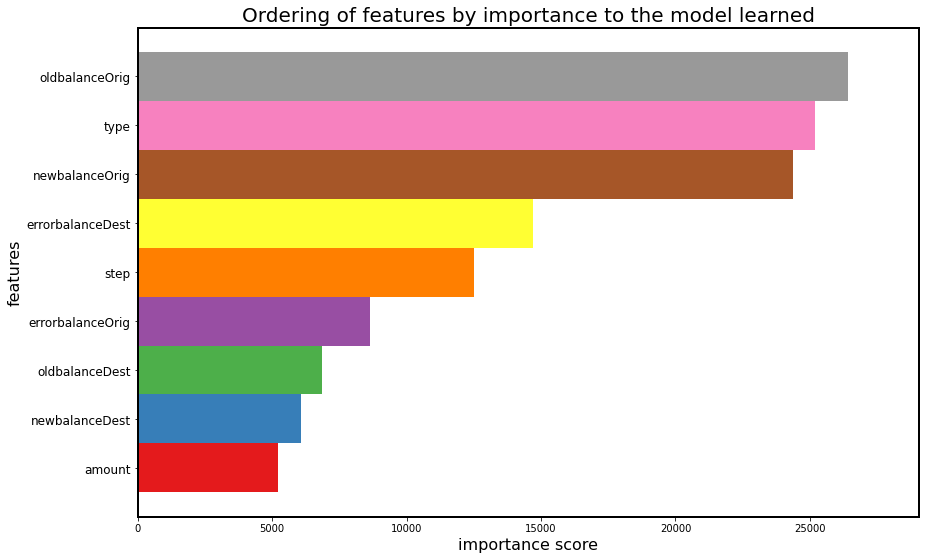

In [16]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(tuned_clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learned', size = 20);

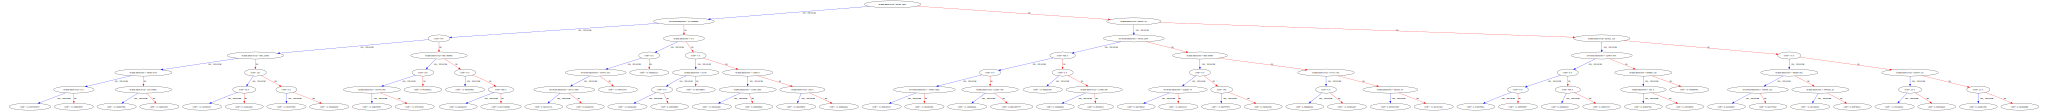

In [17]:
to_graphviz(tuned_clf)

In [18]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(learning_rate = 0.2267, n_estimators = 705, 
              subsample = 0.8556, min_child_weight = 6,
              max_depth = 6, colsample_bytree = 0.6067, 
              scale_pos_weight = weights, n_jobs = -1), trainX, trainY, scoring = 'average_precision')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

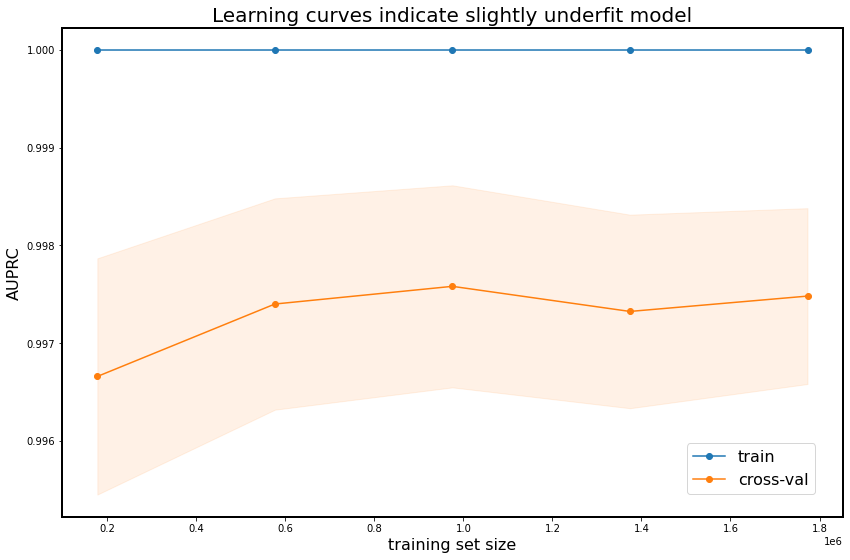

In [19]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);